# Saving the power plants to a GeoJSON

GeoJSONs are a great format to be able to open points very easily. They are basically just geo-located JSON files, which prevent us from having to retrieve the location info from each point with a self-made function each time we want to plot / access to points.

In this short notebook, I'll show how this is done with a library called `geopandas` and how to then simply save this file.

I also created a dataset [here](https://www.kaggle.com/maxlenormand/geolocated-power-plants-geojson) if you simply want to download the `.geojson` file directly.

In [1]:
import numpy as np
import os

import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt

In [2]:
# Geospatial libraries that we will be using for this
import folium
import geopandas as gpd
from shapely.geometry import Point

First we need to find where the location information is in the original `.csv` file:

In [3]:
power_plants = pd.read_csv('/kaggle/input/ds4g-environmental-insights-explorer/eie_data/gppd/gppd_120_pr.csv')
power_plants.columns

Index(['system:index', 'capacity_mw', 'commissioning_year', 'country',
       'country_long', 'estimated_generation_gwh', 'generation_gwh_2013',
       'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016',
       'generation_gwh_2017', 'geolocation_source', 'gppd_idnr', 'name',
       'other_fuel1', 'other_fuel2', 'other_fuel3', 'owner', 'primary_fuel',
       'source', 'url', 'wepp_id', 'year_of_capacity_data', '.geo'],
      dtype='object')

If we take a look at the `.geo` column, we cna see that the location is in a string in there:

In [4]:
# Plotting the .geo info of the first power plant
power_plants['.geo'][0]

'{"type":"Point","coordinates":[-66.6662986370627,18.33589933648736]}'

We can easily extract the longitude & latitude of a given point and keep it as a float

In [5]:
longitude = float(power_plants['.geo'][0].split("[")[1][:-2].split(",")[0])
latitude = float(power_plants['.geo'][0].split("[")[1][:-2].split(",")[1])

print(f'Longitude: {longitude}, lattitude: {latitude}')

Longitude: -66.6662986370627, lattitude: 18.33589933648736


In [6]:
# We can create a new column containing this information
power_plants['longitude'] = [float(power_plants['.geo'][point].split("[")[1][:-2].split(",")[0]) for point in range(power_plants.shape[0])]
power_plants['latitude'] = [float(power_plants['.geo'][point].split("[")[1][:-2].split(",")[1]) for point in range(power_plants.shape[0])]

GeoDataFrames are like pandas DataFrames, except they have an additional column called the `geometry` which will contain Shapely information about the row object given (here it is a point, but it could also be polygons (for boundaries of a country for example) or multipolyons).

In [7]:
geometry_power_plants = [Point(x,y) for x,y in zip(power_plants.longitude, power_plants.latitude)]

In [8]:
del power_plants['.geo']

As we are saving these points with some geo-location information, we need to give it a CRS: Coordinate Reference System. These are just the reference system used to calculate the given longitude and latitude given in the `geometry` column.

In [9]:
gdf_power_plants = gpd.GeoDataFrame(power_plants, crs = {'init': 'epsg: 4326'}, geometry = geometry_power_plants)
gdf_power_plants.head()

,system:index,capacity_mw,commissioning_year,country,country_long,estimated_generation_gwh,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,...,other_fuel3,owner,primary_fuel,source,url,wepp_id,year_of_capacity_data,longitude,latitude,geometry
0,0000000000000000315a,15.0,1942.0,USA,United States of America,685.397712,0.0,0.0,0.0,0.0,...,NaN,PREPA,Hydro,CEPR,http://energia.pr.gov/datos/plantas/,30936.0,0,-66.666299,18.335899,POINT (-66.66630 18.33590)
1,000000000000000026e5,1492.0,1975.0,USA,United States of America,8334.010812,0.0,0.0,0.0,0.0,...,NaN,PREPA,Oil,PREPA,http://www.prepa.com/aguirre.asp,30928.0,0,-66.230796,17.951899,POINT (-66.23080 17.95190)
2,00000000000000002fda,990.0,1962.0,USA,United States of America,5529.940150,0.0,0.0,0.0,0.0,...,NaN,PREPA,Oil,PREPA,http://www.prepa.com/costasur.asp,30934.0,0,-66.753403,18.000298,POINT (-66.75340 18.00030)
3,00000000000000003f76,602.0,1960.0,USA,United States of America,3362.650475,0.0,0.0,0.0,0.0,...,NaN,PREPA,Oil,PREPA,http://www.prepa.com/PALOSECO.ASP,30942.0,0,-66.148597,18.455301,POINT (-66.14860 18.45530)
4,00000000000000002def,10.0,1915.0,USA,United States of America,456.931808,0.0,0.0,0.0,0.0,...,NaN,PREPA,Hydro,PREPA,http://www.prepa.com/historia_eng.asp https:/...,65289.0,0,-66.106004,18.044702,POINT (-66.10600 18.04470)


We can now simply plot this GeoDataFrame

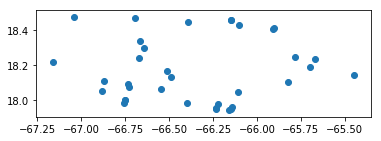

In [10]:
gdf_power_plants.plot()

Just to be sure, we can plot these on a Folium Map, to check that we have the correct CRS and we didn't mess up anything. (You can also check by un-hiding the code, that plotting points on a map with a GeoDataFrame is much easier than if we had to create an additional function to retrieve the longitude and latitude. Technically we could just keep that in a pandas DataFrame, but for the sake of the deomstration, GeoDataFrames are shown here).

In [11]:
# Plot on the map
lat=18.200178; lon=-66.664513
plot = folium.Map(location = (lat, lon), zoom_start=9)

for plant_lat, plant_long in zip(gdf_power_plants.latitude, gdf_power_plants.longitude):
    folium.Marker(location = (plant_lat, plant_long),
                    icon = folium.Icon(color='blue')).add_to(plot)
    
plot

And finally, we want to save this GeoDataFrame to be able to use it later

In [12]:
# Saving the geodataframe for easy use later
gdf_power_plants.to_file('Geolocated_gppd_120_pr.geojson', driver='GeoJSON')

I should add that there are more benefits to making handling GeoJSONs instead of CSVs. For example, we can very easily drop them in QGIS and compare them to any rasters we might have:

![Imgur](https://i.imgur.com/AX4e89p.png)